In [53]:
import matplotlib.pyplot as plt

In [54]:
# dictionary of tick parameters
# For more on customizing matplotlib plots:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
plotparams = {"xtick.direction" : "inout", "ytick.direction" : "inout",
              "xtick.major.size" : 5, "ytick.major.size" : 5,
              "font.size" : 8}

In [55]:
# Units are understood in [kN] and [m]
b = 10.  # half of the total width of the structure in [m]
h = 0.5  # initial height of the structure in [m]
EA = 5000.  # <Young's modulus> * <Cross sectional area> in [kN/m2]
k = 1.0  # spring stiffness [kN/m]
F = 1.5  # applied load in [kN]
v = h/2

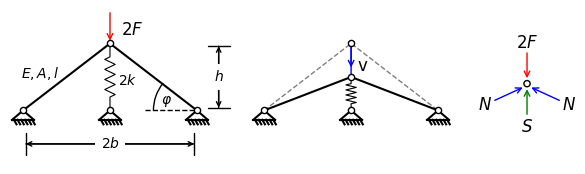

In [56]:
from matplotlib import patheffects, gridspec
from matplotlib.patches import Arc
import numpy as np
from operator import sub

def get_aspect(ax):
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio

def get_max_zorder(ax):
    return max([_.zorder for _ in ax.get_children()])

def annotate_ax(ax, x0, x1, label, arrows=None, c='k', fontsize=10):
    if arrows is None:
        arrows = '<->', '|-|'
    for arr in arrows:
        ax.annotate("", xy=x0, xytext=x1, arrowprops=dict(arrowstyle=arr))
    bbox=dict(fc="white", ec="none")
    ax.text((x0[0]+x1[0])/2, (x0[1]+x1[1])/2, label, color=c, \
        ha="center", va="center", bbox=bbox, fontsize=fontsize)
    
def add_hinge(ax, x, y, s=20, fc='white', ec='k', lw=1, zorder=None, **kwargs):
    if zorder is None:
        zorder = get_max_zorder(ax) + 1
    ax.scatter(x, y, s=s, fc=fc, ec=ec, lw=lw, alpha=1.0, zorder=zorder, **kwargs)

def add_triangle_support(ax, xy, w, h, hinge_params={}):
    x = [xy[0] - w/2, xy[0] + w/2]
    y = [xy[1] - h, xy[1] -h]
    spec = [patheffects.withTickedStroke(angle=-60, spacing=2.5, length=1.5)]
    ax.plot(x, y, color='k', path_effects=spec)
    x = [xy[0] - w/2, xy[0], xy[0] + w/2]
    y = [xy[1] - h, xy[1], xy[1] -h]
    ax.plot(x, y, color='k')
    add_hinge(ax, xy[0], xy[1], **hinge_params)
    
def add_spring(ax, x0, x1, w, lw=0.1, N=2, offset_ratio=0.1):
    coords = []
    x0 = np.array(x0)
    x1 = np.array(x1)
    s = x1 - x0
    L = np.linalg.norm(s)
    d = s/L
    R = np.array([[0, -1], [1, 0]], dtype=float)
    m = R @ (d*w)
    Ls = L*(1-offset_ratio)
    NN = 4*N
    dl = Ls / NN
    coords.append(x0)
    xP = x0 + d*L*offset_ratio/2
    coords.append(xP)
    c, dc, dm = 1, 0, 1
    for _ in range(NN):
        xP = xP + dl*d
        if c == 1:
            dc = -1
            dm = 1
        elif c == -1:
            dc = 1
            dm = 1
        elif c == 0:
            dm = 0
        coords.append(xP + dc*dm*m)
        c += dc      
    coords.append(x1)
    npcoords = np.array(coords)
    ax.plot(npcoords[:, 0], npcoords[:, 1], color='k', lw=lw)
    
x0 = [-b, 0, b]
y0 = [0, h, 0]
x1 = [-b, 0, b]
y1 = [0, h-v, 0]

with plt.style.context('default'), plt.rc_context(plotparams):
    # we create teh figure and the plots in advance
    fig = plt.figure(figsize=(7.12, 2))  # in inches
    gs = gridspec.GridSpec(1, 3, width_ratios=[3, 3, 1])
    
    # first plot (left)
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(x0, y0, 'k-')
    annotate_ax(ax1, (-b, -h/2), (b, -h/2), "$2b$")
    annotate_ax(ax1, (1.25*b, 0), (1.25*b, h), "$h$")
    ax1.set_ylim(-0.8*h, 1.5*h)
    ax1.set_xlim(-1.15*b, 1.25*b)
    ax1.axis('off')
    ax1.annotate("", xy=(0, h + 0.25), xytext=(0, h), \
        arrowprops=dict(arrowstyle='<-', color='r'), fontsize=10)
    bbox=dict(fc="none", ec="none")
    ax1.text(b*0.25, 1.2 *h, '$2F$', ha="center", va="center", bbox=bbox, fontsize=12)
    add_spring(ax1, (0, 0), (0, h), 0.6, lw=0.8, N=4, offset_ratio=0.4)
    ax1.text(b*0.2, 0.45*h, '$2k$', ha="center", va="center", bbox=bbox, fontsize=10)
    ax1.text(-0.8*b, 0.55*h, '$E, A, l$', ha="center", va="center", bbox=bbox, fontsize=10)
    ax1.text(0.65*b, 0.13*h, r'$\varphi$', ha="center", va="center", bbox=bbox, fontsize=10)
    ax1.plot((b*0.4, b), (0, 0), 'k--', lw=1)
    arc = Arc((b, 0), 10, 10/get_aspect(ax1), 0, 177, 180, transform=ax1.transData)
    add_triangle_support(ax1, (-b, 0), 2.5, 0.07)
    add_triangle_support(ax1, (b, 0), 2.5, 0.07)
    add_triangle_support(ax1, (0, 0), 2.5, 0.07)
    ax1.add_patch(arc)
    add_hinge(ax1, 0, h)
    
    # second plot (middle)
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(x1, y1, 'k-', markersize='3')
    ax2.plot(x0, y0, 'k--', alpha=0.5, lw=1)
    add_triangle_support(ax2, (-b, 0), 2.5, 0.07)
    add_triangle_support(ax2, (b, 0), 2.5, 0.07)
    ax2.set_ylim(-0.8*h, 1.5*h)
    ax2.set_xlim(-1.15*b, 1.25*b)
    ax2.axis('off')
    ax2.annotate("", xy=(0, h), xytext=(0, h-v), \
        arrowprops=dict(arrowstyle='-', color='b'), fontsize=10)
    ax2.annotate("", xy=(0, h), xytext=(0, h-v/1.25), \
        arrowprops=dict(arrowstyle='<-', color='b'), fontsize=10)
    bbox=dict(fc="none", ec="none")
    ax2.text(b*0.13, h-v/1.5, 'v', ha="center", va="center", bbox=bbox, fontsize=12)
    add_spring(ax2, (0, 0), (0, h-v), 0.6, lw=0.8, N=4, offset_ratio=0.4)
    add_triangle_support(ax2, (0, 0), 2.5, 0.07)
    add_hinge(ax2, 0, h-v)
    add_hinge(ax2, 0, h)
    
    # third plot (right)
    ax3 = fig.add_subplot(gs[2])
    ax3.set_ylim(-0.8*h, 1.5*h)
    ax3.set_xlim(-b, b)
    ax3.axis('off')
    h -= 0.3
    ax3.scatter( 0 , h , s=20 ,  fc='none', ec='k', lw=1) 
    bbox=dict(fc="none", ec="none")
    # arrow for the external force
    ax3.annotate("", xy=(0, h + 0.25), xytext=(0, h+0.02), \
        arrowprops=dict(arrowstyle='<-', color='r'), fontsize=10)
    ax3.text(0, 0.5, '$2F$', ha="center", va="center", bbox=bbox, fontsize=12)
    # arrow for the spring force
    ax3.annotate("", xy=(0, h-0.25), xytext=(0, h-0.02), \
        arrowprops=dict(arrowstyle='<-', color='g'), fontsize=10)
    ax3.text(0, -0.12, '$S$', ha="center", va="center", bbox=bbox, fontsize=12)
    # arrows for the member forces
    ax3.annotate("", xy=(-b, h/3), xytext=(-b*0.05, h*0.9), \
        arrowprops=dict(arrowstyle='<-', color='blue'), fontsize=10)
    ax3.annotate("", xy=(b, h/3), xytext=(b*0.05, h*0.9), \
        arrowprops=dict(arrowstyle='<-', color='blue'), fontsize=10)
    ax3.text(b*1.2, 0.2 *h, '$N$', ha="center", va="center", bbox=bbox, fontsize=12)
    ax3.text(-b*1.2, 0.2 *h, '$N$', ha="center", va="center", bbox=bbox, fontsize=12)
    
plt.show()

In [57]:
# Units are understood in [kN] and [m]
b = 10.  # half of the total width of the structure in [m]
h = 0.5  # initial height of the structure in [m]
EA = 5000.  # <Young's modulus> * <Cross sectional area> in [kN/m2]
k = 1.0  # spring stiffness [kN/m]
F = 1.5  # applied load in [kN]

In [58]:
from numpy import sqrt
from scipy.optimize import newton

def R(F):
    """
    Returns the residual function R(v). 
    Optimal for a force-controlled analysis, 
    where this function is called in succession 
    for different (probably increasing) load values.
    """
    l0 = sqrt(h**2 + b**2)
    def inner(v):
        l = sqrt((h-v)**2 + b**2)
        return F - k*v + EA*((l-l0)/l0)*((h-v)/l)
    return inner

def Q(v):
    """
    Returns the residual for a candidate solution. 
    Optimal for a displacement-controlled scenario.
    """
    l0 = sqrt(h**2 + b**2)
    def inner(F):
        l = sqrt((h-v)**2 + b**2)
        return F - k*v + EA*((l-l0)/l0)*((h-v)/l)
    return inner

def root(fnc, x0=0, verbose=False):
    """Returns None if things go wrong, returns the
    root(s) of `fnc`. If `verbose` is `True` and 
    things go wrong, it prints the error message."""
    try:
        return newton(fnc, x0)
    except Exception as e:
        if verbose:
            print(e)
        return None

In [59]:
v = root(R(F))

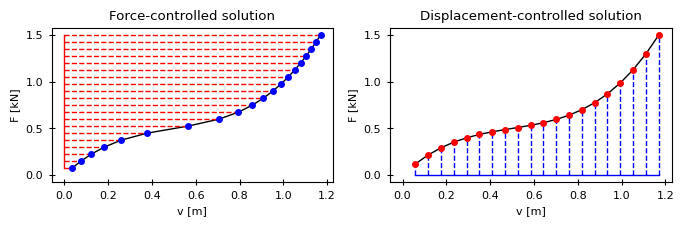

In [60]:
with plt.style.context('default'), plt.rc_context(plotparams):
    # we create teh figure and the plots in advance
    fig = plt.figure(figsize=(8, 2))  # in inches
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    
    nstep = 20
    ydata = [(i+1)*F/nstep for i in range(nstep)]
    xdata1, ydata1 = [], []
    v1, v1_ = 0, 0

    for Fi in ydata:
        v1_ = root(R(Fi), v1)
        if v1_:
            v1 = v1_
            xdata1.append(v1)
            ydata1.append(Fi)
            
    ax1.plot(xdata1, ydata1, lw=1.0, color='k')
    markerline, stemlines, baseline = \
        ax1.stem(ydata1, xdata1, basefmt='r-', orientation='horizontal', \
            linefmt='r--', markerfmt='bo')
    plt.setp(stemlines, 'linewidth', 1)
    plt.setp(baseline, 'linewidth', 1)
    plt.setp(markerline, markersize=4)
    ax1.set_xlabel('v [m]')
    ax1.set_ylabel('F [kN]')
    ax1.set_title('Force-controlled solution')
    
    xdata = [(i+1)*v/nstep for i in range(nstep)]
    xdata1, ydata1 = [], []
    F1, F1_ = 0, 0
    for vi in xdata:
        F1_ = root(Q(vi), F1)
        if F1_:
            F1 = F1_
            xdata1.append(vi)
            ydata1.append(F1)

    ax2.plot(xdata1, ydata1, lw=1.0, color='k')
    markerline, stemlines, baseline = \
        ax2.stem(xdata1, ydata1, basefmt='b-', orientation='vertical', \
            linefmt='b--', markerfmt='ro')
    plt.setp(stemlines, 'linewidth', 1)
    plt.setp(baseline, 'linewidth', 1)
    plt.setp(markerline, markersize=4)
    ax2.set_xlabel('v [m]')
    ax2.set_ylabel('F [kN]')
    ax2.set_title('Displacement-controlled solution')
    plt.show()

# Third plot

In [61]:
def run_F(k_, N=15):
    """
    Convenience function that returns lists of displacements 
    and forces resulting from a force-controlled analysis. 
    The maximum load value `Fmax` is reached in a number of `N` steps.
    """
    global k
    k = k_
    l0 = sqrt(h**2 + b**2)
    f_ext = []
    f_int = []
    disp = []
    v_prev = 0
    for Fi in [i*F/N for i in range(N+1)]:
        try:
            vi = root(R(Fi), v_prev)
            if vi and vi <= v:
                li = sqrt((h-vi)**2 + b**2)
                Ni = EA * (li-l0)/l0
                f_ext.append(Fi)
                f_int.append(Ni)
                disp.append(vi)
                v_prev = vi
        except:
            pass
    return {'d' : disp, 'f_ext' : f_ext, 'f_int' : f_int}

def run_D(k_, N=15):
    """
    Convenience function that returns lists of displacements 
    and forces resulting from a displacement-controlled analysis. 
    The maximum displacement value `vmax` is reached in a number 
    of `N` steps.
    """
    global k
    k = k_
    l0 = sqrt(h**2 + b**2)
    f_ext = []
    f_int = []
    f_spr = []
    disp = []
    F_prev = 0
    for vi in [i*v/N for i in range(N+1)]:
        try:
            Fi = root(Q(vi), F_prev)
            if Fi and Fi <= F:
                li = sqrt((h-vi)**2 + b**2)
                Ni = EA * (li-l0)/l0
                Si = vi*2*k
                f_ext.append(Fi)
                f_int.append(Ni)
                f_spr.append(Si)
                disp.append(vi)
                F_prev = Fi
        except:
            pass
    return {'d' : disp, 'f_ext' : f_ext, 'f_int' : f_int, 'f_spr' : f_spr}

In [62]:
# a sequence of tuples for springs  containing
# (stiffness, marker, color)
springs = [(1.0, 'o', 'blue'), (0.5, '*', 'green'), (0., '^', 'red')]  
db_F = [run_F(k) for k, *_ in springs]  # force-controlled solutions
db_D = [run_D(k) for k, *_ in springs]  # displacement-controlled solutions

In [63]:
def decorate_ax(ax, legend=True, xlabel=None, ylabel=None):
    # labels, grid and legend
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.grid(axis='x', lw = 0.5, linestyle='--', color='black')
    ax.grid(axis='y', lw = 0.5, linestyle='--', color='black')
    if legend:
        ax.legend(loc='upper center', fontsize=8)

    # spines with arrowheads
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.axvline(x=0, color='black', lw=1)
    ax.axhline(y=0, color='black', lw=1)
    ax.plot((1), (0), ls="", marker=">", ms=5, color="black", 
            transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot((0), (1), ls="", marker="^", ms=5, color="black", 
            transform=ax.get_xaxis_transform(), clip_on=False)

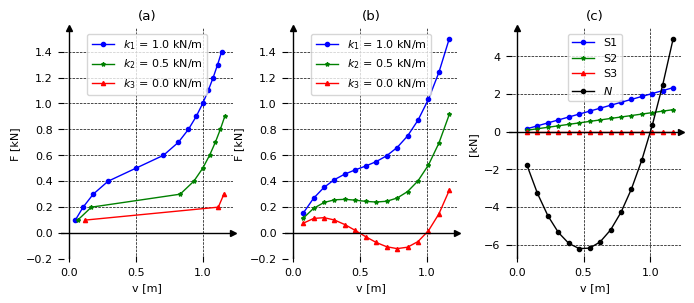

In [64]:

with plt.style.context('default'), plt.rc_context(plotparams):
      # we create teh figure and the plots in advance
      fig = plt.figure(figsize=(8, 3))  # in inches
      ax1 = fig.add_subplot(1, 3, 1)
      ax2 = fig.add_subplot(1, 3, 2, sharex=ax1, sharey=ax1)
      ax3 = fig.add_subplot(1, 3, 3, sharex=ax1)
      
      # force-controlled plots
      for i, (k, m, c) in enumerate(springs):
            label = '$k_{}$ = {} kN/m'.format(i+1, k) 
            ax1.plot(db_F[i]['d'], db_F[i]['f_ext'], label=label, \
                  marker=m, markersize=3, color=c, lw=1.)
            ax3.plot(db_D[i]['d'], db_D[i]['f_spr'], label='S{}'.format(i+1), \
                  marker=m, markersize=3, lw=1., color=c)
      ax1.set_title('(a)')
      decorate_ax(ax1, xlabel='v [m]', ylabel='F [kN]')
      
      # displacement-controlled plots
      for i, (k, m, c) in enumerate(springs):
            label = '$k_{}$ = {} kN/m'.format(i+1, k) 
            ax2.plot(db_D[i]['d'], db_D[i]['f_ext'], label=label, \
                  marker=m, markersize=3, color=c, lw=1.)
      ax2.set_title('(b)')
      decorate_ax(ax2, xlabel='v [m]', ylabel='F [kN]')
      
      # internal force
      ax3.plot(db_D[0]['d'], db_D[0]['f_int'], label='$N$', \
            marker='o', markersize=3, lw=1., color='k')
      ax3.set_title('(c)')    
      ax3.set_title('(c)')
      # decorate
      decorate_ax(ax3, legend=True, xlabel='v [m]', ylabel='[kN]')
            
      # show the plots
      plt.subplots_adjust(wspace=0.3)
      plt.show()
      
      import tikzplotlib

      #tikzplotlib.save("figure.pgf")
      tikzcode = tikzplotlib.get_tikz_code(fig)

In [65]:
tikzcode

'% This file was created with tikzplotlib v0.10.1.\n\\begin{tikzpicture}\n\n\\definecolor{green}{RGB}{0,128,0}\n\\definecolor{lightgray204}{RGB}{204,204,204}\n\n\\begin{groupplot}[group style={group size=3 by 1}]\n\\nextgroupplot[\naxis line style={none},\nlegend cell align={left},\nlegend style={\n  fill opacity=0.8,\n  draw opacity=1,\n  text opacity=1,\n  at={(0.5,0.91)},\n  anchor=north,\n  draw=lightgray204\n},\ntick align=center,\ntick pos=left,\ntitle={(a)},\nxlabel={v [m]},\nxmajorgrids,\nxmin=-0.0584809392293222, xmax=1.22809972381576,\nxtick style={color=black},\nylabel={F [kN]},\nymajorgrids,\nymin=-0.200806188607015, ymax=1.58099077088602,\nytick style={color=black}\n]\n\\addplot [blue, mark=*, mark size=1.5, mark options={solid}]\ntable {%\n0.0482831280790041 0.1\n0.106612101969309 0.2\n0.181959902536214 0.3\n0.293049201697474 0.4\n0.5 0.5\n0.706950798302533 0.6\n0.818040097463605 0.7\n0.893387898030583 0.8\n0.951716871920806 0.9\n1.00000000000001 1\n1.04158780716753 1.1\n

'% This file was created with tikzplotlib v0.10.1.\n\\begin{tikzpicture}\n\n\\definecolor{darkgray176}{RGB}{176,176,176}\n\\definecolor{steelblue31119180}{RGB}{31,119,180}\n\n\\begin{axis}[\ntick align=outside,\ntick pos=left,\ntitle={About as simple as it gets, folks},\nx grid style={darkgray176},\nxlabel={Time [s]},\nxmin=-0.0995, xmax=2.0895,\nxtick style={color=black},\ny grid style={darkgray176},\nylabel={Voltage [mV]},\nymin=-0.1, ymax=2.1,\nytick style={color=black}\n]\n\\addplot [semithick, steelblue31119180]\ntable {%\n0 1\n0.01 1.06279051952931\n0.02 1.1253332335643\n0.03 1.18738131458572\n0.04 1.24868988716485\n0.05 1.30901699437495\n0.06 1.36812455268468\n0.07 1.42577929156507\n0.08 1.48175367410172\n0.09 1.535826794979\n0.1 1.58778525229247\n0.11 1.63742398974869\n0.12 1.68454710592869\n0.13 1.72896862742141\n0.14 1.77051324277579\n0.15 1.80901699437495\n0.16 1.84432792550202\n0.17 1.87630668004386\n0.18 1.90482705246602\n0.19 1.92977648588825\n0.2 1.95105651629515\n0.21 1

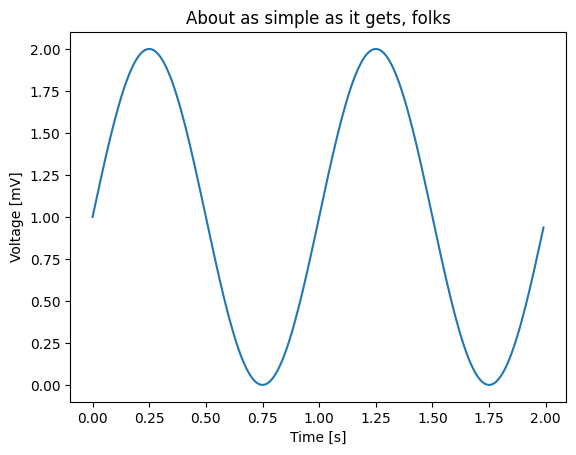

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='Time [s]', ylabel='Voltage [mV]',
       title='About as simple as it gets, folks')

import tikzplotlib
tikzplotlib.get_tikz_code(fig)